In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

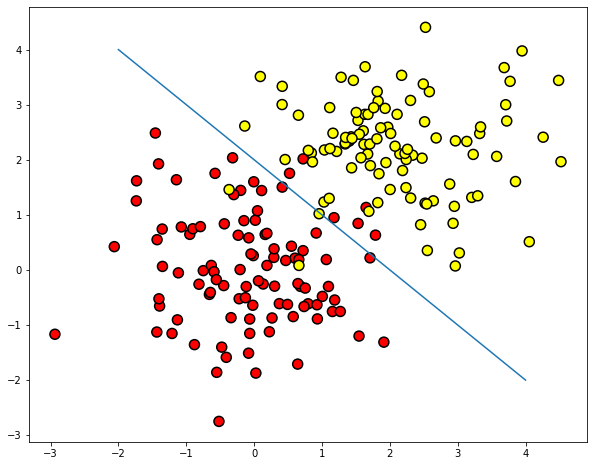

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

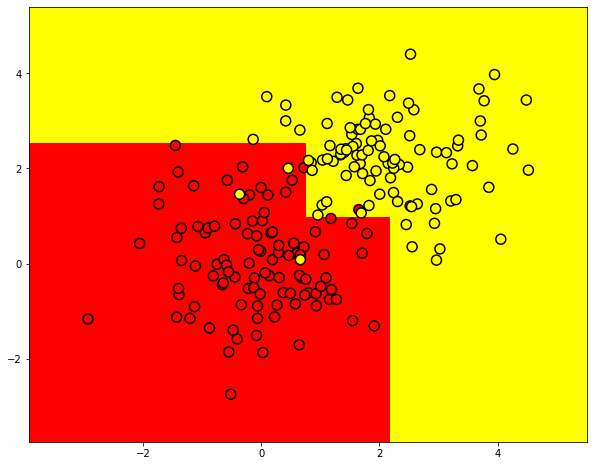

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

In [5]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
out_file='small_tree.dot', filled=True)

In [6]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pydotplus 
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

tree_graph_to_png(tree=clf_tree, feature_names=['x1', 'x2'], 
                  png_file_to_save='decision_tree.png')
    

InvocationException: GraphViz's executables not found

In [8]:
# Считаем данные в DataFrame и проведем предобработку. 
# Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. 
# Первую модель будем обучать без штатов, потом посмотрим, помогают ли они.

df = pd.read_csv('C:/Users/WhiteKisa/Desktop/Python_Sripts/DataSets/telecom.csv')
df.drop(['phone number'], axis=1, inplace=True)
df['international plan'] = pd.factorize(df['international plan'])[0]
df['voice mail plan'] = pd.factorize(df['voice mail plan'])[0]
df['churn'] = df['churn'].astype('int')
states = df['state']
y = df['churn']
df.drop(['state', 'churn'], axis=1, inplace=True)

In [9]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
account length            3333 non-null int64
area code                 3333 non-null int64
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
dtypes: float64(8), int64(10)
memory usage: 468.8

In [10]:
# Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). 
# отложенная выборка никак не будет участвовать в настройке параметров моделей, 
# на ней мы в конце, после этой настройки, оценим качество полученной модели. 
# Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: 
# глубину дерева берем 5, число ближайших соседей – 10.

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')